# numba CUDA와 pycuda 속도 비교

In [21]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

import subprocess


In [22]:
ns = np.arange(30,127,8)

In [ ]:
subprocess.run(["python", "Laplace_numba.py"])
time_numba = np.load("time_numba.npy")

In [27]:
subprocess.run(["python", "Laplace_pycuda.py"])
time_pycuda = np.load("time_pycuda.npy")

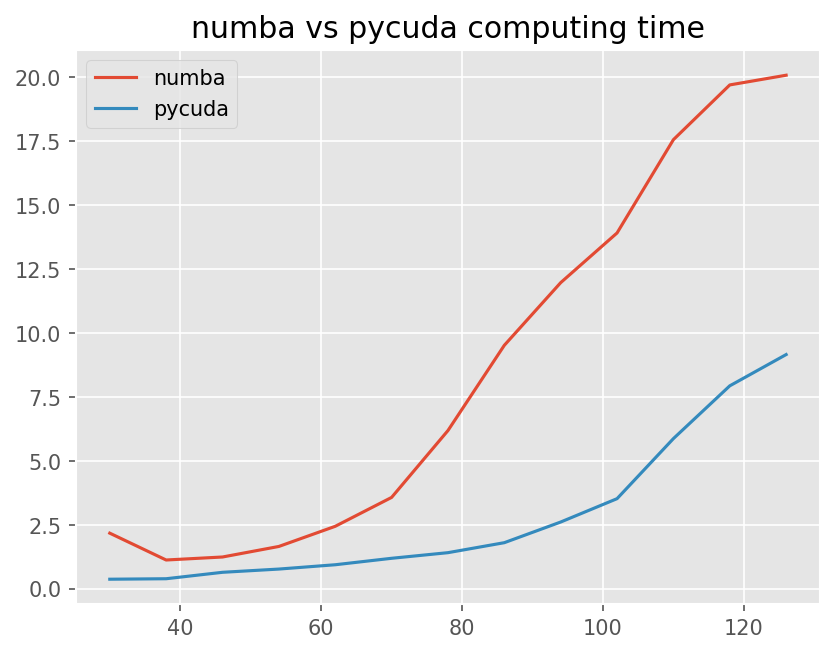

In [29]:
plt.title("numba vs pycuda computing time")
plt.plot(ns, time_numba, label = "numba")
plt.plot(ns, time_pycuda, label = "pycuda")
plt.grid(True)
plt.legend()
plt.show()